In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_h5ad('/ix3/djishnu/alw399/SpaceOracle/data/visiumHD_lymph/training_data/mouse_lymph1_ctrl_visiumHD.h5ad')
adata

AnnData object with n_obs × n_vars = 68275 × 3196
    obs: 'clusters', 'cell_type', 'cell_type_int', 'sample'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

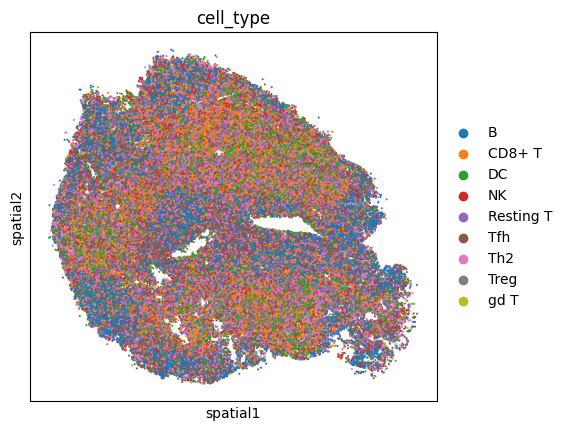

In [4]:
sc.pl.spatial(adata, color='cell_type', spot_size=20)

In [5]:
import sys
sys.path.append('../../src/')

In [6]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [7]:
# %%time

# sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

In [8]:
%matplotlib inline

oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [12]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2
TF dict already exists. The old TF dict data was deleted. 



In [ ]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

 33%|███▎      | 3/9 [1:02:46<2:02:15, 1222.54s/it]

In [ ]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

In [ ]:
import pickle

with open('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_lymph1_ctrl_visiumHD_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [ ]:
links.to_hdf5(file_path="/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_ctrl_visiumHD.celloracle.links")
oracle.to_hdf5("/ix/djishnu/shared/djishnu_kor11/co_objects/mouse_lymph1_ctrl_visiumHD.celloracle.oracle")